In [515]:
import numpy as np
import os
from sklearn.datasets import load_svmlight_file
from scipy import stats
from scipy import sparse
import cvxpy as cp
import matplotlib.pyplot as plt

'''
Example for reading data and the corresponding labels
'''
DATA_DIR = '.'
data_train, label_train = load_svmlight_file(os.path.join(DATA_DIR, 'train.txt'),n_features=60) 
data_test, label_test = load_svmlight_file(os.path.join(DATA_DIR, 'test.txt'),n_features=60) 

# 5.1: Data preprocessing

In [520]:
def preprocessing_train(data):
    """ Argument:
    train_data: N*D matrix, each row as a sample and each column as a feature
    (needs to be dense)
    train_label: N*1 vector, each row as a label
    
    Return: preprocessed train_data where 
    # compute mean for each sample
    # divide each feature by its standard deviation
    """
    datapoints, features = data.shape[0], data.shape[1]
    data_copy = data.copy()
    
    mean_list, std_list = [],[]
    for i in range(features): #no of columns = no of features
        col_i = np.array(data[:,i])         # mean across columns
        mean_i = (1/datapoints) * np.sum(col_i)
        variance_i = (1/(datapoints-1))* np.sum(np.square(col_i- mean_i) )
        std_i = np.sqrt(variance_i) # std across columns
        
        col_i = (col_i-mean_i) # subtract by mean 
        col_i = col_i/ std_i   # divide by std 
        data_copy[:,i] = col_i 
        mean_list.append(mean_i)
        std_list.append(std_i)
    return data_copy, mean_list, std_list

In [521]:
def preprocess_test(test_data, mean_list, std_list):
    test_datapoints, features = test_data.shape[0], test_data.shape[1]
    test_data_copy = test_data.copy()
    
    for i in range(features):
        # no of columns = no of features
        mean_i = mean_list[i]
        std_i = std_list[i]
        col_i = np.array(test_data[:,i])
        
        col_i = (col_i-mean_i) 
        col_i = col_i/ std_i
        test_data_copy[:,i] = col_i
    
    return test_data_copy

In [525]:
preprocessed_train, mean_list, std_list = preprocessing_train(data_train.todense())
preprocessed_test = preprocess_test(data_test.todense(), mean_list, std_list)

print("2nd feture: mean is {:.3f}, std is {:.3f}".format(mean_list[1], std_list[1]))
print("9th feture: mean is {:.3f}, std is {:.3f}".format(mean_list[8], std_list[8]))

2nd feture: mean is 2.460, std is 1.122
9th feture: mean is 2.537, std is 1.106


---
# 5.2: Implement linear SVM

$$ \min_{w,b,\xi}  \frac{1}{2} \| w\|_2^2+ C \sum_{i=1}^N \xi_i $$

$$\text{subject to} \quad  \xi_i \geq 0, \; i=1,\ldots N$$

$$y_i(w^Tx_i  +  b) \geq 1-\xi_i, \;
        i=1,\ldots N$$

In [523]:


def train_svm(train_data, train_label, C):
  """Train linear SVM (primal form)
  Argument:
    train_data: N*D matrix, each row as a sample and each column as a feature
    train_label: N*1 vector, each row as a label
    C: tradeoff parameter (on slack variable side)

  Return:
    w: feature vector (column vector)
    b: bias term
"""
  
  N, d = train_data.shape[0], train_data.shape[1]
  w = cp.Variable((d,1))
  b = cp.Variable(1)
  xi = cp.Variable((N,1))
  y = np.expand_dims(train_label, axis = 1)

  objective = cp.Minimize(0.5 * cp.norm(w)**2 + C * cp.sum(xi)) # w = d * 1, x_i = d*1, train_data = N * d, y = N*1
  constraints = [xi >=0, cp.multiply(y, train_data@w + b) >=1 - xi]
  problem = cp.Problem(objective=objective, constraints=constraints)
  result = problem.solve()
  
  w, b= w.value, b.value
  return w, b

In [557]:
# test
w, b = train_svm(preprocessed_train, label_train, C = .001)

In [558]:
def test_svm(test_data, test_label, w, b):
  """Test linear SVM

  Argument:
    test_data: M*D matrix, each row as a sample and each column as a feature
    test_label: M*1 vector, each row as a label
    w: feature vector
    b: bias term

  Return
    test_accuracy: a float between [0, 1] representing the test accuracy
  """
  pred =  np.sign(test_data@w + b)
  test_label = np.expand_dims(test_label, axis = 1)
  misclassifications = np.sum(pred!=test_label)
  error_rate = misclassifications/ test_data.shape[0]
  return error_rate

In [559]:
test_svm(preprocessed_test, label_test, w, b)

0.152183908045977

___
# 5.3: Cross validation for linear SVM

In [445]:
def cross_val_split(X, y, batch_number):
    n, d = X.shape
    fold_size = n // batch_number  # Size of each fold
    train_split_total, val_split_total = [], []
    label_list_train, label_list_val= [], []
            
    preprocessed_train = []
    preprocessed_val = []

    for i in range(batch_number):
        val_start = i * fold_size
        val_end = val_start + fold_size

        val_split = X[val_start:val_end]
        val_label = y[val_start:val_end]
        
        train_split_before, train_label_before= X[:val_start], y[:val_start]
        train_split_after,train_label_after = X[val_end:], y[val_end:] 

        if train_split_before.shape[0] ==0: # train_split_before is 0
            train_split = train_split_after
            train_label = train_label_after
        elif train_split_after.shape[0] == 0: # train_split_after is 0
            train_split= train_split_before
            train_label = train_label_before

        else: 
            train_split = np.concatenate((train_split_before, train_split_after), 
                                         axis=0)
            train_label =  np.concatenate((train_label_before, train_label_after), 
                                         axis=0)
            
        data_train_preprocessed, mean_list, std_list = preprocessing_train(train_split)
        data_val_preprocessed = preprocess_test(val_split,mean_list, std_list )
        
        preprocessed_train.append(data_train_preprocessed)
        label_list_train.append(train_label)
        preprocessed_val.append(data_val_preprocessed)
        label_list_val.append(val_label)
    
    preprocessed_train = np.array(preprocessed_train)
    preprocessed_val = np.array(preprocessed_val)
    label_list_train = np.array(label_list_train)
    label_list_val = np.array(label_list_val)
    
    return preprocessed_train, preprocessed_val, label_list_train, label_list_val

In [560]:
total_train, total_val, train_label, val_label =  cross_val_split(data_train.todense(), label_train, batch_number=10)

In [563]:
C_list = np.array([4**(-6+i) for i in range(0,10)])
C_list

array([2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
       6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
       1.60000000e+01, 6.40000000e+01])

In [571]:
def cross_val_error(X_train, y_train, C_list, num_folds=10):
    total_train, total_val, train_label, val_label = cross_val_split(X_train, y_train, batch_number=num_folds)
    mean_error_per_C = []
    
    for C in C_list:
        error_per_batch = []
        for i in range(num_folds):
            w, b = train_svm(total_train[i], train_label[i], C)
            error = test_svm(total_val[i], val_label[i], w, b)
            error_per_batch.append(error)
        mean_error_per_C.append(np.mean(error_per_batch))
    
    return mean_error_per_C

In [572]:
C_list = np.array([4**(-6+i) for i in range(0,10)])
errors = cross_val_error(data_train.todense(), label_train, C_list)
min_index = np.argmin(errors)

In [579]:
for i in range(len(errors)):
    print("Accuracy = {:.4f} for C = {:.4f}".format(100*(1-errors[i]), C_list[i]))

Accuracy = 51.9000 for C = 0.0002
Accuracy = 79.3000 for C = 0.0010
Accuracy = 80.7000 for C = 0.0039
Accuracy = 82.0000 for C = 0.0156
Accuracy = 81.5000 for C = 0.0625
Accuracy = 80.3000 for C = 0.2500
Accuracy = 80.5000 for C = 1.0000
Accuracy = 80.9000 for C = 4.0000
Accuracy = 80.9000 for C = 16.0000
Accuracy = 81.0000 for C = 64.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


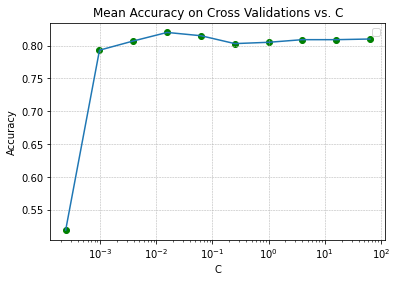

In [583]:
plt.plot(C_list, 1-np.array(errors) )
plt.scatter(C_list, 1-np.array(errors), color='green')
plt.xscale('log')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy on Cross Validations vs. C")
plt.legend()
plt.savefig("Crossval_Clist.png", dpi=400)

In [584]:
min_index, C_list[min_index], errors[min_index]

(3, 0.015625, 0.18)

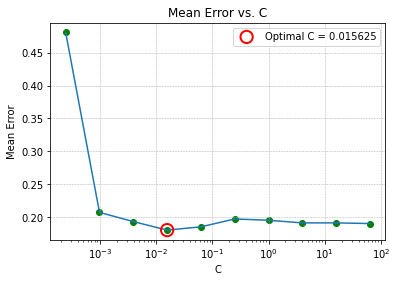

In [575]:
# Plotting
plt.plot(C_list, errors)
plt.scatter(C_list, errors, color='green')
plt.xscale('log')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("C")
plt.ylabel("Mean Error")
plt.scatter(C_list[min_index], errors[min_index], edgecolors='red', 
            facecolors='none', s=150, linewidth=2, zorder=5, label=f'Optimal C = {C_list[min_index]}')
plt.title("Mean Error vs. C")
plt.legend()
plt.savefig("C_meanerror.png", dpi=400)

In [576]:
print(C_list[min_index], 4**-3)
print(r"Optimal C value is 4^(-3)")

0.015625 0.015625
Optimal C value is 4^(-3)


# Test Accuracy

In [568]:
preprocessed_train, mean_list, std_list = preprocessing_train(data_train.todense())
preprocessed_test = preprocess_test(data_test.todense(), mean_list, std_list)

In [569]:
w, b = train_svm(preprocessed_train, label_train, C = 4**-3)
test_error = test_svm(preprocessed_test, label_test, w, b)

In [570]:
print("Test error is {:.3f}%, Test Accuracy is {:.3f}%".format(100* test_error, 100*(1-test_error) ) )

Test error is 15.356%, Test Accuracy is 84.644%
